# 7章 線形モデル上のバンディット問題の実装

Author: hagino3000  
Date: 2016-11-30

「バンディット問題の理論とアルゴリズム」[1] の7章のアルゴリズムを実装して動かしてみる．  
報酬が正規分布のパターン  

- LinUCB
- 線形モデル上のトンプソン抽出


[1] 「バンディット問題の理論とアルゴリズム」本多淳也／中村篤祥・著 http://www.kspub.co.jp/book/detail/1529175.html

## 実験データ

報酬はネット広告のCPMとする  
デザインとフォントは時刻tのコンテキスト(オーディエンス属性)に依存する，コンテキスト付きバンディット問題

In [1]:
# 真の報酬モデル
campaigns = {
    'campaign_a': 10,
    'campaign_b': 13,
    'campaign_c': 19,
    'campaign_d': 16,
    'campaign_e': 18,
    'campaign_f': 18
}
attribute = {
    'men_20': 1,
    'men_30': 50,
    'female_20': 8,
    'female_30': 20  
}
# デザインとfontはユーザー属性に依存して報酬が決まる
contextual_attrs = {
    'men_20': {
        'design': {
            'a': 20,
            'b': -1,
            'c': 16,
            'd': 17
        },
        'font': {'a': 10, 'b': 5}
    },
    'men_30': {
        'design': {
            'a': 5,
            'b': -1,
            'c': 3,
            'd': 4
        },
        'font': {'a': 10, 'b': -1}
    },
    'female_20': {
        'design': {
            'a': -20,
            'b': 40,  
            'c': 30,
            'd': 35
        },
        'font': {'a': 5,'b': -10}
    }, 
    'female_30': {
        'design': {
            'a': -10,
            'b': 20, 
            'c': 15,
            'd': 17
        },
        'font': {'a': -5, 'b': 3}
    }
}

contextual_columns = []
contextual_values = []
for attr, attr_v in contextual_attrs.items():
    for el, el_v in attr_v.items():
        for type_name, value in el_v.items():
            contextual_columns.append(attr + '_' + el + '_' + type_name)
            contextual_values.append(value)

actions = []
for a in [campaigns.keys(), attribute.keys(), contextual_columns]:
    actions.extend(a)
theta = []
for a in [campaigns.values(), attribute.values(), contextual_values]:
    theta.extend(a)

In [2]:
# actionの要素
print(actions)

['campaign_b', 'campaign_e', 'campaign_a', 'campaign_c', 'campaign_d', 'campaign_f', 'men_30', 'men_20', 'female_20', 'female_30', 'men_30_design_a', 'men_30_design_b', 'men_30_design_c', 'men_30_design_d', 'men_30_font_a', 'men_30_font_b', 'men_20_design_a', 'men_20_design_b', 'men_20_design_c', 'men_20_design_d', 'men_20_font_a', 'men_20_font_b', 'female_20_design_a', 'female_20_design_b', 'female_20_design_c', 'female_20_design_d', 'female_20_font_a', 'female_20_font_b', 'female_30_design_a', 'female_30_design_b', 'female_30_design_c', 'female_30_design_d', 'female_30_font_a', 'female_30_font_b']


In [3]:
# 真の\theta
print(theta)

[13, 18, 10, 19, 16, 18, 50, 1, 8, 20, 5, -1, 3, 4, 10, -1, 20, -1, 16, 17, 10, 5, -20, 40, 30, 35, 5, -10, -10, 20, 15, 17, -5, 3]


In [4]:
# 真の分散
var = [
    64, 81, 64, 32, 32, 32, # campaign (a,b,c,d)
    16, 16, 16, 16,       # ユーザー属性
    128, 128, 64, 10, 9, 9,   # men_20
    64, 64, 64, 10, 9, 9,     # men_30
    128, 128, 64, 10, 16, 16, # female_20
    64, 64, 64, 10, 16, 16    # female_30
]

In [5]:
empty_row = {}
for c in actions:
    empty_row[c] = 0

In [6]:
print(empty_row)

{'campaign_b': 0, 'men_20': 0, 'female_20_design_c': 0, 'men_20_font_a': 0, 'female_20_design_d': 0, 'men_20_design_a': 0, 'men_20_design_d': 0, 'men_30_font_b': 0, 'men_30_design_b': 0, 'men_20_design_c': 0, 'female_20_design_a': 0, 'men_30': 0, 'men_30_design_d': 0, 'female_20_design_b': 0, 'female_30_font_b': 0, 'campaign_d': 0, 'female_30_design_d': 0, 'men_30_design_c': 0, 'men_20_font_b': 0, 'men_30_design_a': 0, 'campaign_e': 0, 'female_30_font_a': 0, 'female_30_design_a': 0, 'female_20_font_b': 0, 'campaign_f': 0, 'female_30_design_c': 0, 'men_30_font_a': 0, 'campaign_a': 0, 'female_20_font_a': 0, 'men_20_design_b': 0, 'campaign_c': 0, 'female_30': 0, 'female_30_design_b': 0, 'female_20': 0}


In [7]:
ret = []
for k, v in campaigns.items():
    cp = k
    cp_value = v
    for k, v in attribute.items():
        attr = k
        attr_value = v
        for k, v in contextual_attrs[attr]['design'].items():
            design = k
            design_value = v
            for k, v in contextual_attrs[attr]['font'].items():
                font = k
                font_value = v
                row = empty_row.copy()
                row[cp] = 1
                row[attr] = 1
                row[attr + '_design_' + design] = 1
                row[attr + '_font_' + font] = 1
                ret.append(row)

## 選択可能なactionの組み合わせ

In [8]:
df_actions = pd.DataFrame.from_dict(ret)
df_actions = df_actions[actions]
df_actions

,campaign_b,campaign_e,campaign_a,campaign_c,campaign_d,campaign_f,men_30,men_20,female_20,female_30,...,female_20_design_c,female_20_design_d,female_20_font_a,female_20_font_b,female_30_design_a,female_30_design_b,female_30_design_c,female_30_design_d,female_30_font_a,female_30_font_b
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 真の期待値と真の分散から報酬を生成する
cov = np.identity(len(var))*var
def get_reward(action):
    return sum(np.random.multivariate_normal(action.T*theta, cov)*action)

# コンテキストの生成
contexts = [k for k in attribute.keys()]
def get_context(t):
    return contexts[t % len(contexts)]

## LinUCB

118頁，アルゴリズム7.1

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2, \alpha > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\hat{\theta} \leftarrow A^{-1}b. \\
\hspace{10pt}//\ 各行動iについてUCBスコアの計算，ただし \alpha_t = \alpha\sqrt{logt} \\
\hspace{10pt}\overline{\mu_i} = a_{i,t}^{\mathrm{T}}\hat{\theta} + \alpha_t\sigma\sqrt{a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}\\
\hspace{10pt}スコア最大の行動\ i\ \leftarrow\ argmax_i\overline{\mu_i}_(t) を選択して報酬 X(t) を観測 \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [10]:
def calc_new_a_inv(A_inv, a_i_t):
    return A_inv - (A_inv*(np.matrix(a_i_t).T)*(a_i_t)*A_inv)/(1 + a_i_t.dot(A_inv).dot(a_i_t))

In [11]:
def linucb(T=1000, input_sigma2=600, param_sigma02=300, param_alpha=10):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))    

    # results
    rewards = []
    for t in range(1, T):
        alpha_t = param_alpha*np.sqrt(np.log(t))
        theta_hat = A_inv.A.dot(b)
        context = get_context(t)
        ucb_scores = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            ucb_score = a_i.dot(theta_hat) + alpha_t*np.sqrt(input_sigma2)*np.sqrt(a_i.dot(A_inv).dot(a_i))
            selectable_actions.append(a_i)
            ucb_scores.append(ucb_score)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(ucb_scores).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [12]:
theta_hat, rewards, b = linucb(T=100)

In [13]:
theta_hat

array([ 14.53061365,   9.78462332,   9.71007363,  14.58204499,
        17.01065977,  14.69544093,  30.59600655,  13.95948132,
        17.49680942,  18.26115901,  11.4884724 ,   6.90732137,
         5.22941458,   6.97079821,  19.30198941,  11.29401714,
        10.79295043,  -7.61631206,   6.48850423,   4.29433873,
         9.76500159,   4.19447973, -24.58929766,  19.26854197,
        10.35454461,  12.4630205 ,  13.28393645,   4.21287297,
        -6.30122581,   8.31559702,  11.21558378,   5.03120402,
         3.8246519 ,  14.4365071 ])

In [14]:
b

array([  856.4513572 ,   722.34134241,   736.97551954,   892.26361629,
        1043.59357427,   870.56997045,  1667.47811359,  1006.72586595,
        1243.82953542,  1204.1618652 ,   447.58529452,   410.93608622,
         397.5128319 ,   411.44390094,   889.79486272,   777.68325087,
         341.39186993,   119.95002905,   305.08046894,   240.30349803,
         603.05227993,   403.67358602,    13.27846259,   514.6666897 ,
         320.62109798,   395.26328514,   717.9124203 ,   525.91711512,
         212.74721487,   311.18866351,   395.3124673 ,   284.91351952,
         506.58255834,   697.57930686])

In [15]:
def run_linucb_test(T, trial, param_sigma02=300, param_alpha=10, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = linucb(T=T, param_sigma02=param_sigma02, param_alpha=param_alpha)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

Theta - ThetaHat:63.725991464525215


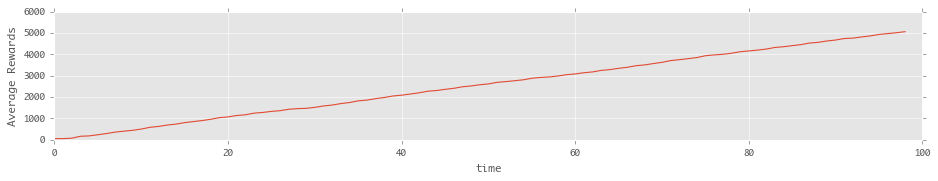

In [16]:
rewards = run_linucb_test(T=100, trial=10)

## パラメータチューニング

In [17]:
rewards_1 = run_linucb_test(T=200, trial=10, param_alpha=0.5, plot=False)
rewards_2 = run_linucb_test(T=200, trial=10, param_alpha=1, plot=False)
rewards_3 = run_linucb_test(T=200, trial=10, param_alpha=10, plot=False)

Theta - ThetaHat:257.03402780757153
Theta - ThetaHat:90.46384226519248
Theta - ThetaHat:56.88788795419678


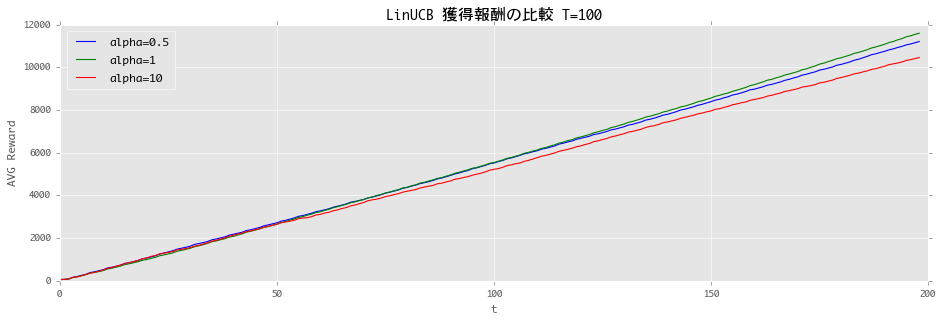

In [18]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='alpha=0.5')
plt.plot(rewards_2, color='g', label='alpha=1')
plt.plot(rewards_3, color='r', label='alpha=10')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'LinUCB 獲得報酬の比較 T=100')

# 正規分布モデルのThompson抽出

121頁, アルゴリズム7.2

入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2 > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\tilde{\theta}\ を多変量正規分布\ N(A^{-1}b, \sigma^2A^{-1})\ から生成. \\
\hspace{10pt}i \leftarrow argmax_i\tilde{\theta}^{\mathrm{T}}_a{i,t} を選択して報酬 X(t) を観測. \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [19]:
def thompson_sampling(T=1000, input_sigma2=600, param_sigma02=300):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))

    # results
    rewards = []
    for t in range(1, T):
        theta_hat = np.random.multivariate_normal(A_inv.A.dot(b), input_sigma2*A_inv)
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = a_i.T.dot(theta_hat)
            selectable_actions.append(a_i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(estimated_rewards).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [20]:
def run_thompson_test(T, trial, param_sigma02=300, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = thompson_sampling(T=T, param_sigma02=param_sigma02)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

In [21]:
# T=50でテスト
theta_hat, rewards, b = thompson_sampling(50)

In [22]:
# 全ての項から報酬が発生している (選択した) 事を確認
b

array([ 177.10981489,  767.60378005,   78.26496963,   64.03909114,
        670.36470162,  852.19817323,  793.22636584,  532.44309037,
        683.78695961,  600.12411474,  124.37953194,  534.01684212,
         70.74918421,   64.08080757,  337.00157908,  456.22478676,
        276.75009065,   15.20556368,   50.06212916,  190.42530687,
        263.89670732,  268.54638305,   -6.97339226,  366.26848043,
        210.22934029,  114.26253115,  637.75802219,   46.02893742,
        120.3080005 ,  188.64823895,   50.09302538,  241.07484991,
        229.95235362,  370.17176112])

In [23]:
# t=50時点での\theta_hat
theta_hat

array([ 24.07216274,  22.98629102, -18.31993822,  51.58168936,
         6.51475214,  10.50800333,  -2.89270074,  12.34578023,
        21.90048015,  39.11116141,  19.96005306,  15.09704087,
        17.13343085,  -3.196844  ,  26.59533384,  32.54684625,
        20.84462828,   2.34040877,  14.01844919,  18.38577395,
        17.68934943,   1.08709252,  -6.65323407,   3.84993341,
        37.35664516,  39.66359091,   3.49748522, -15.02561303,
        12.23708412,  -1.56656816,   2.2747278 ,  13.31612231,
        -9.98406846,   3.80514864])

Theta - ThetaHat:207.6028828218782


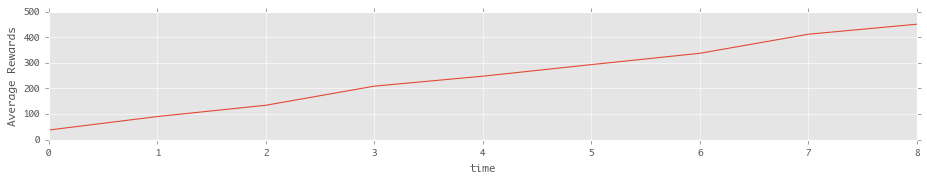

In [24]:
rewards_result = run_thompson_test(T=10, trial=20)

Theta - ThetaHat:81.85155468519741


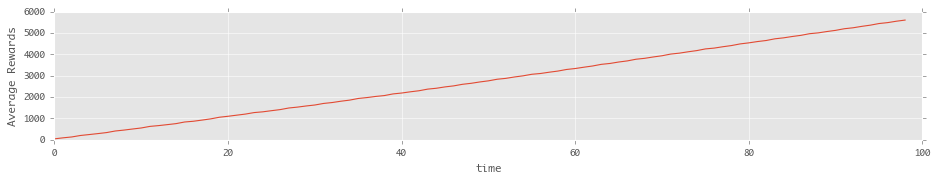

In [25]:
rewards_result = run_thompson_test(T=100, trial=20)

Theta - ThetaHat:51.01937271706911


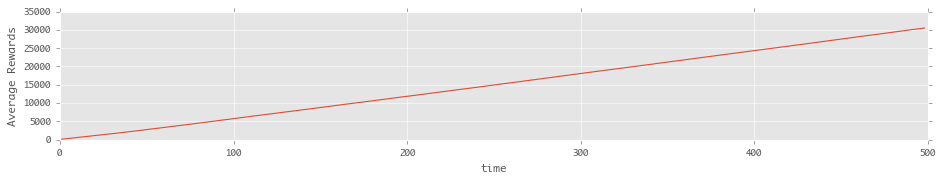

In [26]:
rewards_result = run_thompson_test(T=500, trial=20)

## パラメータチューニング

In [27]:
rewards_1 = run_thompson_test(T=200, trial=10, param_sigma02=1, plot=False)
rewards_2 = run_thompson_test(T=200, trial=10, param_sigma02=10, plot=False)
rewards_3 = run_thompson_test(T=200, trial=10, param_sigma02=100, plot=False)
rewards_4 = run_thompson_test(T=200, trial=10, param_sigma02=700, plot=False)
rewards_5 = run_thompson_test(T=200, trial=10, param_sigma02=1500, plot=False)

Theta - ThetaHat:328.6442545756642
Theta - ThetaHat:229.50188291634032
Theta - ThetaHat:94.99269819170101
Theta - ThetaHat:36.96957365265881
Theta - ThetaHat:7.9246099354507695


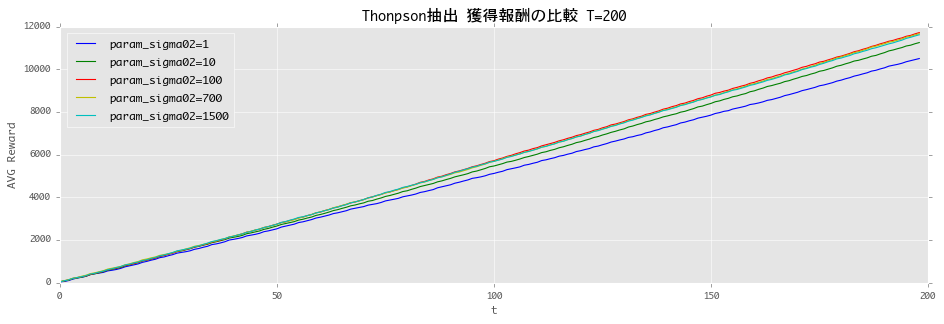

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(rewards_1, color='b', label='param_sigma02=1')
plt.plot(rewards_2, color='g', label='param_sigma02=10')
plt.plot(rewards_3, color='r', label='param_sigma02=100')
plt.plot(rewards_4, color='y', label='param_sigma02=700')
plt.plot(rewards_5, color='c', label='param_sigma02=1500')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'Thonpson抽出 獲得報酬の比較 T=200')

## 比較用のepsilon greedy実装

In [29]:
def epsilon_greedy(T=1000, epsilon=0.1):
    # results
    rewards = []
    selected_counts = np.zeros(len(df_actions))
    gained_rewards = np.zeros(len(df_actions))
    for t in range(1, T):
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_actions_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = gained_rewards[i]/selected_counts[i]
            selectable_actions.append(a_i)
            selectable_actions_idx.append(i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        if np.random.rand() > epsilon:
            _idx = np.array(estimated_rewards).argmax()
        else:
            # 探索
            _idx = np.random.randint(len(selectable_actions))
        a_i_t = selectable_actions[_idx]
        action_idx = selectable_actions_idx[_idx]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        rewards.append(reward)
        selected_counts[action_idx] += 1
        gained_rewards[action_idx] += reward

    return np.array(rewards), selected_counts

In [30]:
def run_epsilon_greedy_test(T, trial, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        rewards, selected_counts = epsilon_greedy(T=T)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

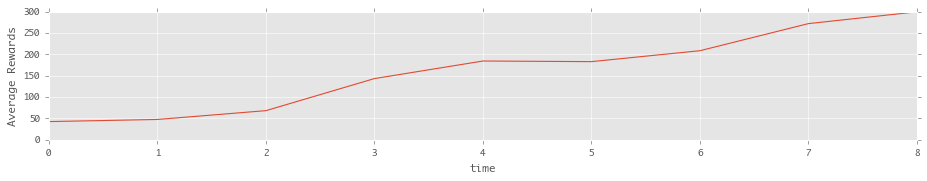

In [31]:
_, selected_count = run_epsilon_greedy_test(10, trial=20, plot=True)

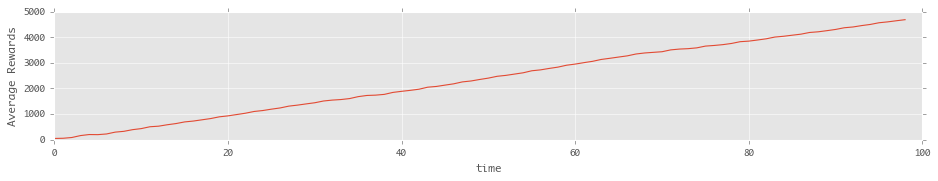

In [32]:
_, selected_count = run_epsilon_greedy_test(100, trial=20, plot=True)

In [33]:
selected_count

array([ 1.  ,  1.05,  1.  ,  1.05,  1.05,  1.1 ,  1.05,  1.  ,  1.05,
        1.  ,  1.05,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.05,  1.  ,
        1.  ,  1.  ,  1.1 ,  1.  ,  1.  ,  1.05,  1.  ,  1.05,  1.1 ,
        1.  ,  1.05,  1.  ,  1.05,  1.  ,  1.  ,  1.05,  1.05,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.05,  1.1 ,  1.05,  1.  ,  1.05,
        1.  ,  1.05,  1.  ,  1.05,  1.  ,  1.05,  1.  ,  1.05,  1.05,
        1.05,  1.  ,  1.  ,  1.05,  1.  ,  1.  ,  1.05,  1.  ,  1.05,
        1.  ,  1.  ,  1.  ,  1.05,  0.95,  0.95,  0.7 ,  0.6 ,  0.15,
        1.05,  1.  ,  1.05,  1.  ,  0.95,  0.85,  0.6 ,  0.5 ,  1.05,
        1.  ,  1.05,  1.  ,  1.  ,  0.95,  0.7 ,  0.65,  1.  ,  1.  ,
        0.95,  0.95,  0.95,  0.85,  0.75,  0.55,  0.  ,  0.05,  0.05,
        0.  ,  0.05,  0.05,  0.05,  0.05,  0.15,  0.05,  0.05,  0.1 ,
        0.15,  0.  ,  0.15,  0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.2 ,  0.15,  0.05,  0.25,  0.05,  0.  ,  0.1 ,  0.05,  0.1 ,
        0.  ,  0.05,

## 比較

In [38]:
T=100
trial=10
result_ep, selected_ep = run_epsilon_greedy_test(T=T, trial=trial, plot=False)
result_ucb = run_linucb_test(T=T, trial=trial, param_alpha=1, plot=False)
result_thompson = run_thompson_test(T=T, trial=trial, param_sigma02=1500, plot=False)

Theta - ThetaHat:244.02451579349977
Theta - ThetaHat:6.4405172936127455


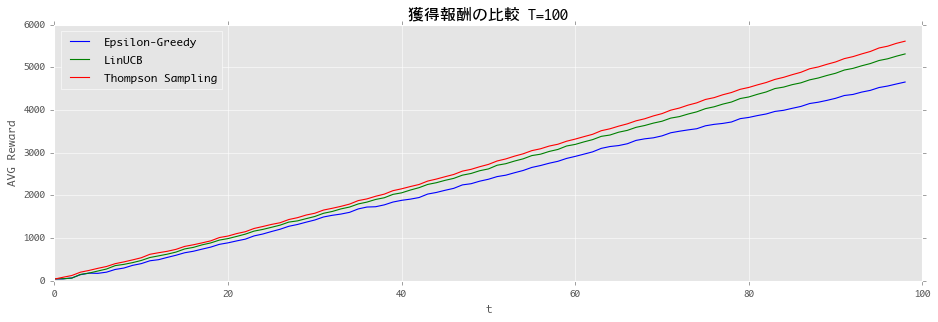

In [39]:
plt.figure(figsize=(14, 4))
plt.plot(result_ep, color='b', label='Epsilon-Greedy')
plt.plot(result_ucb, color='g', label='LinUCB')
plt.plot(result_thompson, color='r', label='Thompson Sampling')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'獲得報酬の比較 T={}'.format(T))

In [40]:
T=500
trial=10
result_ep, selected_ep = run_epsilon_greedy_test(T=T, trial=trial, plot=False)
result_ucb = run_linucb_test(T=T, trial=trial, param_alpha=1, plot=False)
result_thompson = run_thompson_test(T=T, trial=trial, param_sigma02=1500, plot=False)

Theta - ThetaHat:66.48742196571689
Theta - ThetaHat:127.27522657399402


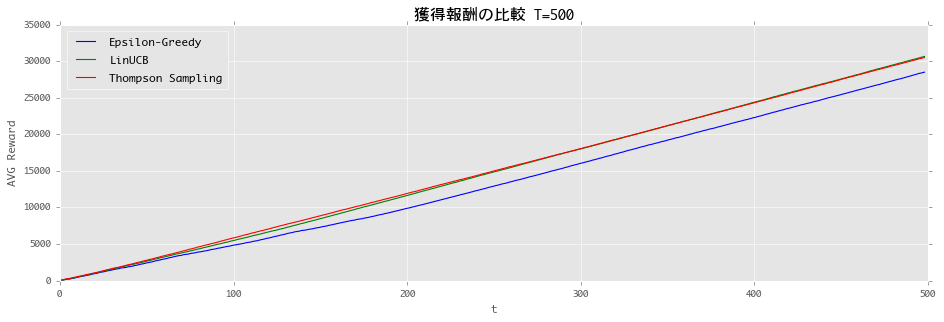

In [41]:
plt.figure(figsize=(14, 4))
plt.plot(result_ep, color='b', label='Epsilon-Greedy')
plt.plot(result_ucb, color='g', label='LinUCB')
plt.plot(result_thompson, color='r', label='Thompson Sampling')
plt.ylabel('AVG Reward')
plt.xlabel('t')
plt.legend(loc='best')
plt.title(u'獲得報酬の比較 T={}'.format(T))

T=100あたりで差が付くが，T=500あたりでLinUCBがThompson抽出に追いつく